# Homework

Apply `BatchNorm`, `Dropout` and `Residual` on MLP networks for CIFAR-10 classification.

For BatchNorm and Dropout, design models with `BatchNorm Layer`, `Dropout Layer` and both the layers. Compare the results with a plain MLP, and with each other.

For Residual, design a simple `Redisual Block` based on a deeper MLP. Compare the results and see whether adding residual works.

Follow the pipeline in your Homework 1 to finish model designing, training and testing.

### Step 1: Load Dataset

In [16]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

# 设置 matplotlib 显示格式
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # 设置默认图像大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# CIFAR-10 数据集的下载和加载
transform = transforms.Compose(
    [transforms.ToTensor(),  # 转换为 Tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # 归一化
)

In [17]:
from torch.utils.data import Dataset, DataLoader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
class OursDatasetwithTransforms(Dataset):
    def __init__(self, data, labels, transforms):
        """
        初始化数据集
        data: 输入数据，例如一个 NumPy 数组或 PyTorch 张量
        labels: 对应的标签
        """
        self.data = data
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        # 每个Dataset都必须写，返回数据集的大小
        return len(self.data)

    def __getitem__(self, idx):
        # 每个Dataset都必须写，获取指定索引idx的数据和标签
        sample = self.data[idx]
        label = self.labels[idx]
        sample = self.transforms(sample)
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
        
transform = transforms.Compose(
    [transforms.ToTensor(),  # [0, 255], PIL Image / ndarray --> [0, 1], torch.tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # 归一化, (input[channel] - mean[channel]) / std[channel]
)
traindata = trainset.data[:5000]
trainlabels = trainset.targets[:5000]
testdata = testset.data[:500]
testlabels = testset.targets[:500]

# 初始化自定义数据集
trainset = OursDatasetwithTransforms(traindata, trainlabels, transform)
testset = OursDatasetwithTransforms(testdata, testlabels, transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=False, drop_last=False)
testloader = DataLoader(testset, batch_size=256, shuffle=False, drop_last=False)

In [18]:
# Helper functions for plotting the loss values
from typing import List, Optional
def plot_loss(num_epochs: int, train_losses: List, test_losses: List, title: str = 'Training and Testing Loss over Epochs', save_path: Optional[str] = None) -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss', marker='x')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

### Step 2: Design a 3-Layer MLP with BatchNorm and Dropout

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Here is the simple version of A 3-layer MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # For CIFAR-10, input size is 32x32x3
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)  # Output size is 10 classes for CIFAR-10
    
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Implentation of MLP with BatchNorm only
# Use nn.BatchNorm1d
class MLPWithBatchNorm(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512):
        super(MLPWithBatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
    
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# Implentation of MLP with Dropout only 
# Use nn.Dropout
class MLPWithDropout(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512, dropout_prob=0.5):
        super(MLPWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_size, 10)
    
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
# Implentation of MLP with both BatchNorm and Dropout  
# Use nn.BatchNorm1d and nn.Dropout  
class MLPWithBatchNormDropout(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512, dropout_prob=0.5):
        super(MLPWithBatchNormDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_size, 10)
    
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.dropout1(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x

In [20]:
# Training and Testing Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def test(model, test_loader):
    criterion = nn.CrossEntropyLoss()
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

### Step 3: Train the networks

In [21]:
# Hyper parameters
num_epochs = 10

Training SimpleMLP...


C:\Users\ljy\AppData\Local\Temp\ipykernel_16756\2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch [1/10], Train Loss: 1.9423, Train Acc: 30.64%, Test Loss: 1.8077, Test Acc: 35.00%
Epoch [2/10], Train Loss: 1.7129, Train Acc: 38.80%, Test Loss: 1.7155, Test Acc: 38.20%
Epoch [2/10], Train Loss: 1.7129, Train Acc: 38.80%, Test Loss: 1.7155, Test Acc: 38.20%
Epoch [3/10], Train Loss: 1.5787, Train Acc: 44.64%, Test Loss: 1.7160, Test Acc: 38.20%
Epoch [3/10], Train Loss: 1.5787, Train Acc: 44.64%, Test Loss: 1.7160, Test Acc: 38.20%
Epoch [4/10], Train Loss: 1.4602, Train Acc: 50.02%, Test Loss: 1.7122, Test Acc: 39.00%
Epoch [4/10], Train Loss: 1.4602, Train Acc: 50.02%, Test Loss: 1.7122, Test Acc: 39.00%
Epoch [5/10], Train Loss: 1.3499, Train Acc: 54.76%, Test Loss: 1.7449, Test Acc: 37.40%
Epoch [5/10], Train Loss: 1.3499, Train Acc: 54.76%, Test Loss: 1.7449, Test Acc: 37.40%
Epoch [6/10], Train Loss: 1.2515, Train Acc: 58.96%, Test Loss: 1.7794, Test Acc: 39.80%
Epoch [6/10], Train Loss: 1.2515, Train Acc: 58.96%, Test Loss: 1.7794, Test Acc: 39.80%
Epoch [7/10], Train L

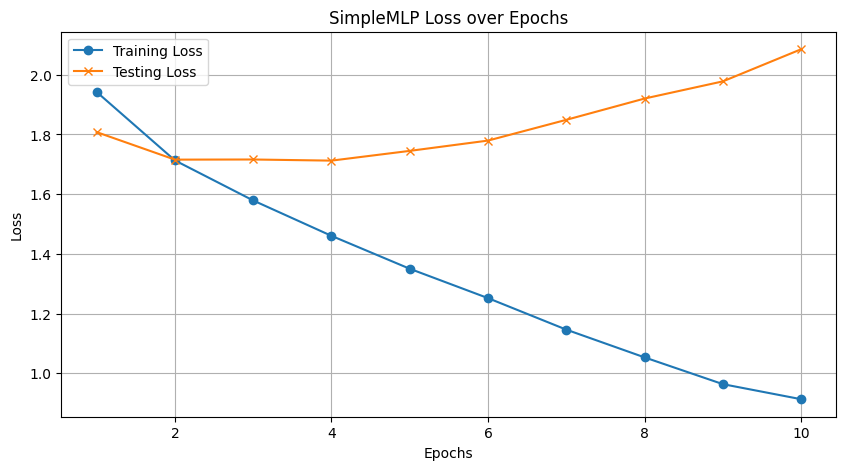

In [22]:
# Train SimpleMLP
simple_mlp = SimpleMLP().to(device)
simple_train_losses, simple_test_losses = [], []
simple_train_accs, simple_test_accs = [], []

print("Training SimpleMLP...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(simple_mlp, trainloader)
    test_loss, test_acc = test(simple_mlp, testloader)
    simple_train_losses.append(train_loss)
    simple_test_losses.append(test_loss)
    simple_train_accs.append(train_acc)
    simple_test_accs.append(test_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

plot_loss(
    num_epochs,
    simple_train_losses,
    simple_test_losses,
    title='SimpleMLP Loss over Epochs',
    save_path='results/simpleMLP_loss_acc_curve.png'
 )

Training MLPWithBatchNorm...


C:\Users\ljy\AppData\Local\Temp\ipykernel_16756\2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch [1/10], Train Loss: 1.8669, Train Acc: 33.60%, Test Loss: 1.7518, Test Acc: 37.40%
Epoch [2/10], Train Loss: 1.6492, Train Acc: 40.82%, Test Loss: 1.7073, Test Acc: 36.60%
Epoch [2/10], Train Loss: 1.6492, Train Acc: 40.82%, Test Loss: 1.7073, Test Acc: 36.60%
Epoch [3/10], Train Loss: 1.4680, Train Acc: 48.60%, Test Loss: 1.6678, Test Acc: 36.60%
Epoch [3/10], Train Loss: 1.4680, Train Acc: 48.60%, Test Loss: 1.6678, Test Acc: 36.60%
Epoch [4/10], Train Loss: 1.3019, Train Acc: 55.64%, Test Loss: 1.6865, Test Acc: 39.00%
Epoch [4/10], Train Loss: 1.3019, Train Acc: 55.64%, Test Loss: 1.6865, Test Acc: 39.00%
Epoch [5/10], Train Loss: 1.1454, Train Acc: 62.26%, Test Loss: 1.7293, Test Acc: 38.20%
Epoch [5/10], Train Loss: 1.1454, Train Acc: 62.26%, Test Loss: 1.7293, Test Acc: 38.20%
Epoch [6/10], Train Loss: 1.0103, Train Acc: 67.66%, Test Loss: 1.7923, Test Acc: 37.20%
Epoch [6/10], Train Loss: 1.0103, Train Acc: 67.66%, Test Loss: 1.7923, Test Acc: 37.20%
Epoch [7/10], Train L

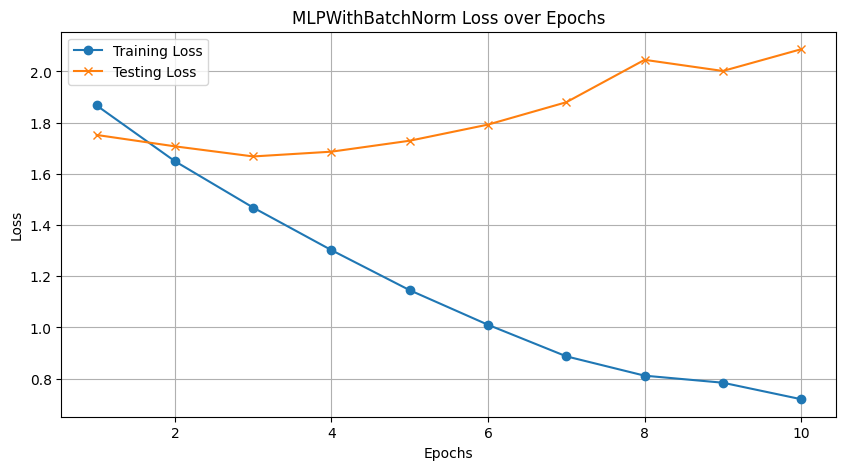

In [23]:
# Train MLPWithBatchNorm
bn_mlp = MLPWithBatchNorm().to(device)
bn_train_losses, bn_test_losses = [], []
bn_train_accs, bn_test_accs = [], []

print("Training MLPWithBatchNorm...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(bn_mlp, trainloader)
    test_loss, test_acc = test(bn_mlp, testloader)
    bn_train_losses.append(train_loss)
    bn_test_losses.append(test_loss)
    bn_train_accs.append(train_acc)
    bn_test_accs.append(test_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

plot_loss(
    num_epochs,
    bn_train_losses,
    bn_test_losses,
    title='MLPWithBatchNorm Loss over Epochs',
    save_path='results/batchnorm_loss_acc_curve.png'
 )

Training MLPWithDropout...


C:\Users\ljy\AppData\Local\Temp\ipykernel_16756\2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch [1/10], Train Loss: 2.0711, Train Acc: 24.90%, Test Loss: 1.8565, Test Acc: 33.00%
Epoch [2/10], Train Loss: 1.8912, Train Acc: 32.06%, Test Loss: 1.7662, Test Acc: 35.80%
Epoch [2/10], Train Loss: 1.8912, Train Acc: 32.06%, Test Loss: 1.7662, Test Acc: 35.80%
Epoch [3/10], Train Loss: 1.8002, Train Acc: 35.78%, Test Loss: 1.7309, Test Acc: 38.40%
Epoch [3/10], Train Loss: 1.8002, Train Acc: 35.78%, Test Loss: 1.7309, Test Acc: 38.40%
Epoch [4/10], Train Loss: 1.7414, Train Acc: 38.22%, Test Loss: 1.6904, Test Acc: 39.80%
Epoch [4/10], Train Loss: 1.7414, Train Acc: 38.22%, Test Loss: 1.6904, Test Acc: 39.80%
Epoch [5/10], Train Loss: 1.7056, Train Acc: 39.26%, Test Loss: 1.6938, Test Acc: 39.00%
Epoch [5/10], Train Loss: 1.7056, Train Acc: 39.26%, Test Loss: 1.6938, Test Acc: 39.00%
Epoch [6/10], Train Loss: 1.6571, Train Acc: 41.86%, Test Loss: 1.6901, Test Acc: 39.00%
Epoch [6/10], Train Loss: 1.6571, Train Acc: 41.86%, Test Loss: 1.6901, Test Acc: 39.00%
Epoch [7/10], Train L

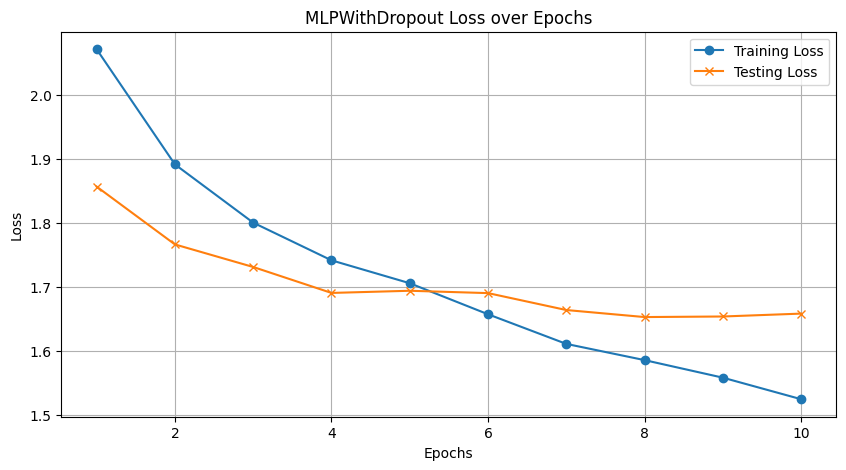

In [24]:
# Training MLPWithDropout
dropout_mlp = MLPWithDropout().to(device)
dropout_train_losses, dropout_test_losses = [], []
dropout_train_accs, dropout_test_accs = [], []

print("Training MLPWithDropout...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(dropout_mlp, trainloader)
    test_loss, test_acc = test(dropout_mlp, testloader)
    dropout_train_losses.append(train_loss)
    dropout_test_losses.append(test_loss)
    dropout_train_accs.append(train_acc)
    dropout_test_accs.append(test_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

plot_loss(
    num_epochs,
    dropout_train_losses,
    dropout_test_losses,
    title='MLPWithDropout Loss over Epochs',
    save_path='results/dropout_loss_acc_curve.png'
 )

Training MLPWithBatchNormDropout...


C:\Users\ljy\AppData\Local\Temp\ipykernel_16756\2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch [1/10], Train Loss: 2.0617, Train Acc: 25.46%, Test Loss: 1.8468, Test Acc: 35.00%
Epoch [2/10], Train Loss: 1.8675, Train Acc: 32.66%, Test Loss: 1.7675, Test Acc: 36.40%
Epoch [2/10], Train Loss: 1.8675, Train Acc: 32.66%, Test Loss: 1.7675, Test Acc: 36.40%
Epoch [3/10], Train Loss: 1.7523, Train Acc: 37.32%, Test Loss: 1.7069, Test Acc: 38.00%
Epoch [3/10], Train Loss: 1.7523, Train Acc: 37.32%, Test Loss: 1.7069, Test Acc: 38.00%
Epoch [4/10], Train Loss: 1.6817, Train Acc: 41.00%, Test Loss: 1.6713, Test Acc: 37.40%
Epoch [4/10], Train Loss: 1.6817, Train Acc: 41.00%, Test Loss: 1.6713, Test Acc: 37.40%
Epoch [5/10], Train Loss: 1.6309, Train Acc: 42.06%, Test Loss: 1.6615, Test Acc: 38.20%
Epoch [5/10], Train Loss: 1.6309, Train Acc: 42.06%, Test Loss: 1.6615, Test Acc: 38.20%
Epoch [6/10], Train Loss: 1.5715, Train Acc: 44.70%, Test Loss: 1.6586, Test Acc: 37.40%
Epoch [6/10], Train Loss: 1.5715, Train Acc: 44.70%, Test Loss: 1.6586, Test Acc: 37.40%
Epoch [7/10], Train L

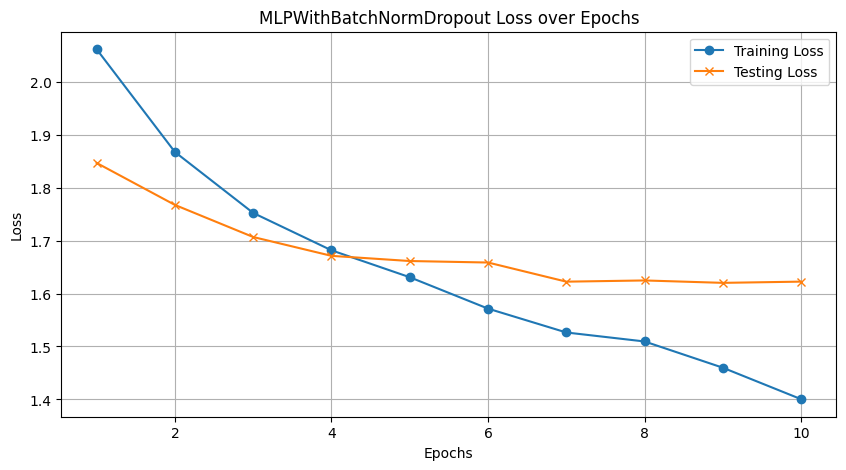

In [25]:
# Training MLPWithBatchNormDropout
bn_dropout_mlp = MLPWithBatchNormDropout().to(device)
bn_dropout_train_losses, bn_dropout_test_losses = [], []
bn_dropout_train_accs, bn_dropout_test_accs = [], []

print("Training MLPWithBatchNormDropout...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(bn_dropout_mlp, trainloader)
    test_loss, test_acc = test(bn_dropout_mlp, testloader)
    bn_dropout_train_losses.append(train_loss)
    bn_dropout_test_losses.append(test_loss)
    bn_dropout_train_accs.append(train_acc)
    bn_dropout_test_accs.append(test_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

plot_loss(
    num_epochs,
    bn_dropout_train_losses,
    bn_dropout_test_losses,
    title='MLPWithBatchNormDropout Loss over Epochs',
    save_path='results/batchnorm_dropout_loss_acc_curve.png'
 )

#### Question: Analysis the results and find out whether any of the above techniques is useful for training this MLP for CIFAR-10 classification. Explain why/how they work?

### Step4: Design a MLP that has deeper layers with Redisual Blocks

In [26]:
# A deeper MLP with 50 layers
class DeepMLP(nn.Module):
    def __init__(self, input_size=32*32*3, num_classes=10, hidden_size=512, num_layers=50):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        
        # Stack multiple hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size) for _ in range(num_layers)
        ])
        self.bn_layers = nn.ModuleList([
            nn.BatchNorm1d(hidden_size) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        
        x = x.view(-1, 32*32*3)
        x = F.relu(self.bn1(self.fc1(x)))

        # Pass through deep hidden layers
        for i in range(len(self.hidden_layers)):
            x = F.relu(self.bn_layers[i](self.hidden_layers[i](x)))
        
        # Output layer for classification
        x = self.fc_out(x)
        
        return x

In [27]:
# Design a residual block
# input -> Linear -> batchnorm -> activation -> dropout -> Linear -> batchnorm -> skip connection -> activation -> output
class ResidualMLPBlock(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob=0.5):
        super(ResidualMLPBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
    
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = self.bn2(self.fc2(out))
        out += residual
        out = F.relu(out)
        return out

# Design MLP with residual blocks
# Use nn.ModuleList 
# input -> Linear -> batchnorm -> activation -> residual layers -> classifacation layer
class DeepResidualMLP(nn.Module):
    def __init__(self, input_size=32*32*3, num_classes=10, hidden_size=512, num_layers=50, dropout_prob=0.5):
        super(DeepResidualMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        
        self.residual_blocks = nn.ModuleList([
            ResidualMLPBlock(hidden_size, hidden_size, dropout_prob) 
            for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.bn1(self.fc1(x)))
        
        for block in self.residual_blocks:
            x = block(x)
        
        x = self.fc_out(x)
        return x

Training DeepMLP...


C:\Users\ljy\AppData\Local\Temp\ipykernel_16756\2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch [1/10], Train Loss: 2.3477, Train Acc: 10.42%, Test Loss: 2.3101, Test Acc: 8.00%
Epoch [2/10], Train Loss: 2.2645, Train Acc: 13.74%, Test Loss: 18.3138, Test Acc: 11.60%
Epoch [2/10], Train Loss: 2.2645, Train Acc: 13.74%, Test Loss: 18.3138, Test Acc: 11.60%
Epoch [3/10], Train Loss: 2.3062, Train Acc: 12.28%, Test Loss: 192.8495, Test Acc: 9.40%
Epoch [3/10], Train Loss: 2.3062, Train Acc: 12.28%, Test Loss: 192.8495, Test Acc: 9.40%
Epoch [4/10], Train Loss: 2.3160, Train Acc: 10.98%, Test Loss: 2.4082, Test Acc: 7.60%
Epoch [4/10], Train Loss: 2.3160, Train Acc: 10.98%, Test Loss: 2.4082, Test Acc: 7.60%
Epoch [5/10], Train Loss: 2.3350, Train Acc: 11.18%, Test Loss: 2.3866, Test Acc: 12.20%
Epoch [5/10], Train Loss: 2.3350, Train Acc: 11.18%, Test Loss: 2.3866, Test Acc: 12.20%
Epoch [6/10], Train Loss: 2.3264, Train Acc: 10.28%, Test Loss: 14.0580, Test Acc: 10.20%
Epoch [6/10], Train Loss: 2.3264, Train Acc: 10.28%, Test Loss: 14.0580, Test Acc: 10.20%
Epoch [7/10], Trai

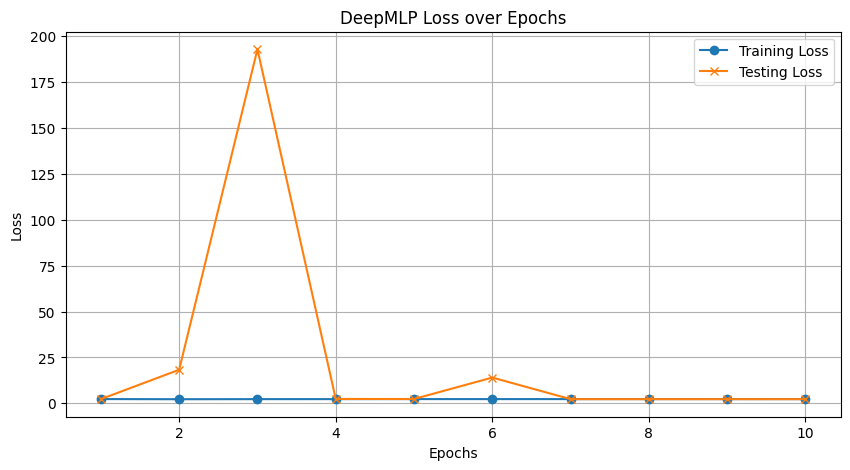

In [28]:
# Training DeepMLP
deep_mlp = DeepMLP().to(device)
deep_train_losses, deep_test_losses = [], []
deep_train_accs, deep_test_accs = [], []

print("Training DeepMLP...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(deep_mlp, trainloader)
    test_loss, test_acc = test(deep_mlp, testloader)
    deep_train_losses.append(train_loss)
    deep_test_losses.append(test_loss)
    deep_train_accs.append(train_acc)
    deep_test_accs.append(test_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# Save the losses during training and testing and plot them using plot_loss()
plot_loss(
    num_epochs,
    deep_train_losses,
    deep_test_losses,
    title='DeepMLP Loss over Epochs',
    save_path='results/deepMLP_loss_acc_curve.png'
 )

Training DeepResidualMLP...


C:\Users\ljy\AppData\Local\Temp\ipykernel_16756\2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch [1/10], Train Loss: 4.7265, Train Acc: 13.88%, Test Loss: 8.3822, Test Acc: 20.00%
Epoch [2/10], Train Loss: 3.9055, Train Acc: 17.62%, Test Loss: 55.7820, Test Acc: 21.20%
Epoch [2/10], Train Loss: 3.9055, Train Acc: 17.62%, Test Loss: 55.7820, Test Acc: 21.20%
Epoch [3/10], Train Loss: 3.1445, Train Acc: 21.56%, Test Loss: 39.6230, Test Acc: 20.40%
Epoch [3/10], Train Loss: 3.1445, Train Acc: 21.56%, Test Loss: 39.6230, Test Acc: 20.40%
Epoch [4/10], Train Loss: 2.8080, Train Acc: 23.18%, Test Loss: 7.8714, Test Acc: 26.20%
Epoch [4/10], Train Loss: 2.8080, Train Acc: 23.18%, Test Loss: 7.8714, Test Acc: 26.20%
Epoch [5/10], Train Loss: 2.4060, Train Acc: 27.60%, Test Loss: 4.3460, Test Acc: 31.20%
Epoch [5/10], Train Loss: 2.4060, Train Acc: 27.60%, Test Loss: 4.3460, Test Acc: 31.20%
Epoch [6/10], Train Loss: 2.2948, Train Acc: 29.52%, Test Loss: 2.6271, Test Acc: 34.20%
Epoch [6/10], Train Loss: 2.2948, Train Acc: 29.52%, Test Loss: 2.6271, Test Acc: 34.20%
Epoch [7/10], Tra

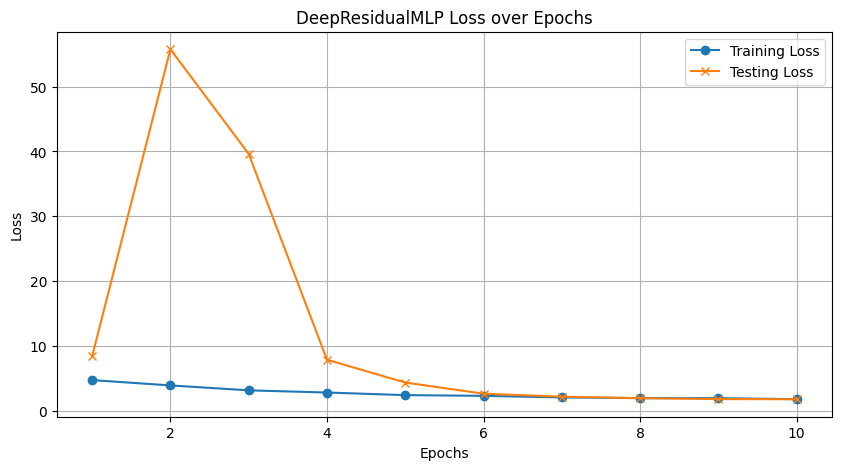

In [29]:
# Training DeepResidualMLP
residual_mlp = DeepResidualMLP().to(device)
residual_train_losses, residual_test_losses = [], []
residual_train_accs, residual_test_accs = [], []

print("Training DeepResidualMLP...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(residual_mlp, trainloader)
    test_loss, test_acc = test(residual_mlp, testloader)
    residual_train_losses.append(train_loss)
    residual_test_losses.append(test_loss)
    residual_train_accs.append(train_acc)
    residual_test_accs.append(test_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# Save the losses during training and testing and plot them using plot_loss()
plot_loss(
    num_epochs,
    residual_train_losses,
    residual_test_losses,
    title='DeepResidualMLP Loss over Epochs',
    save_path='results/deepResidualMLP_loss_acc_curve.png'
 )

#### Bonus: Try to see the gradient flow when training the above networks

C:\Users\ljy\AppData\Local\Temp\ipykernel_16756\2358819985.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Visualizing gradient flow for SimpleMLP...


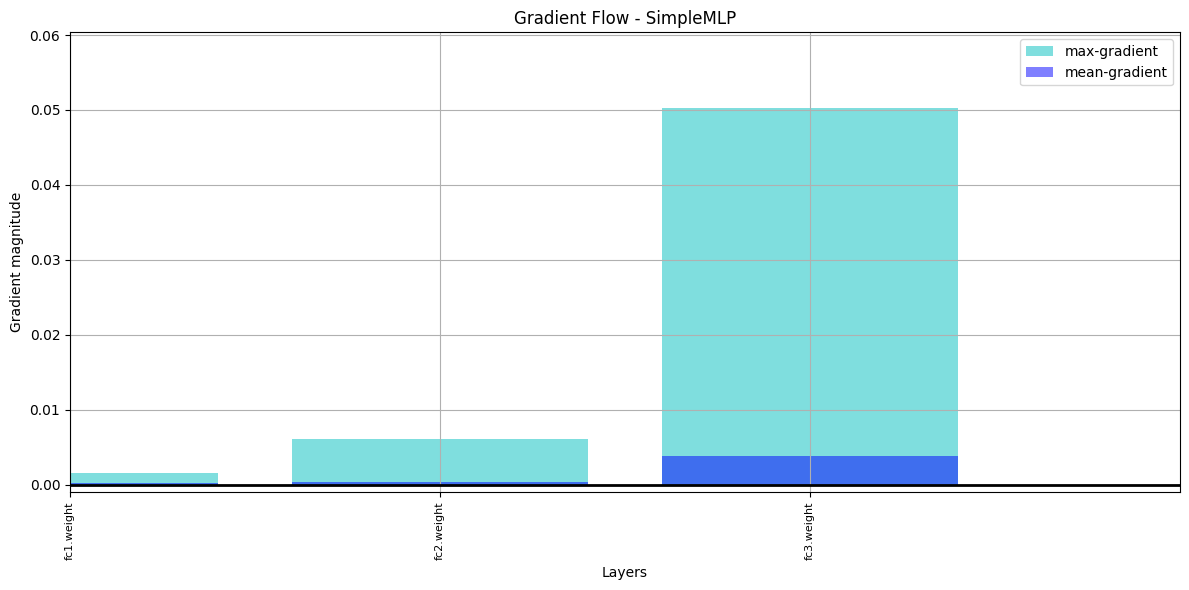

Visualizing gradient flow for MLPWithBatchNorm...


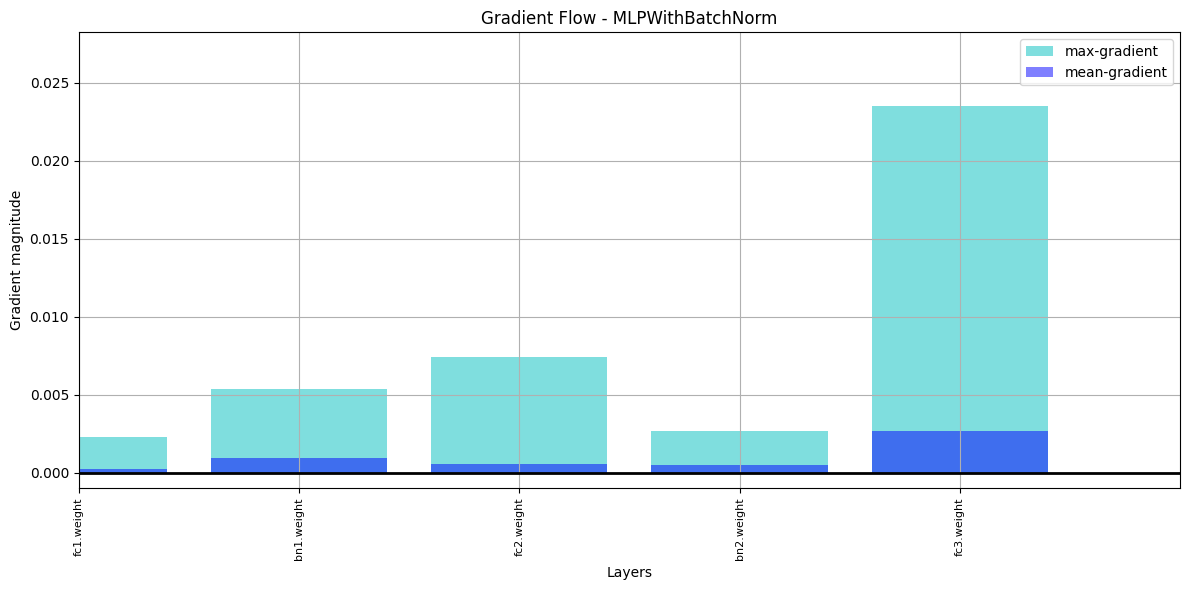

Visualizing gradient flow for MLPWithDropout...


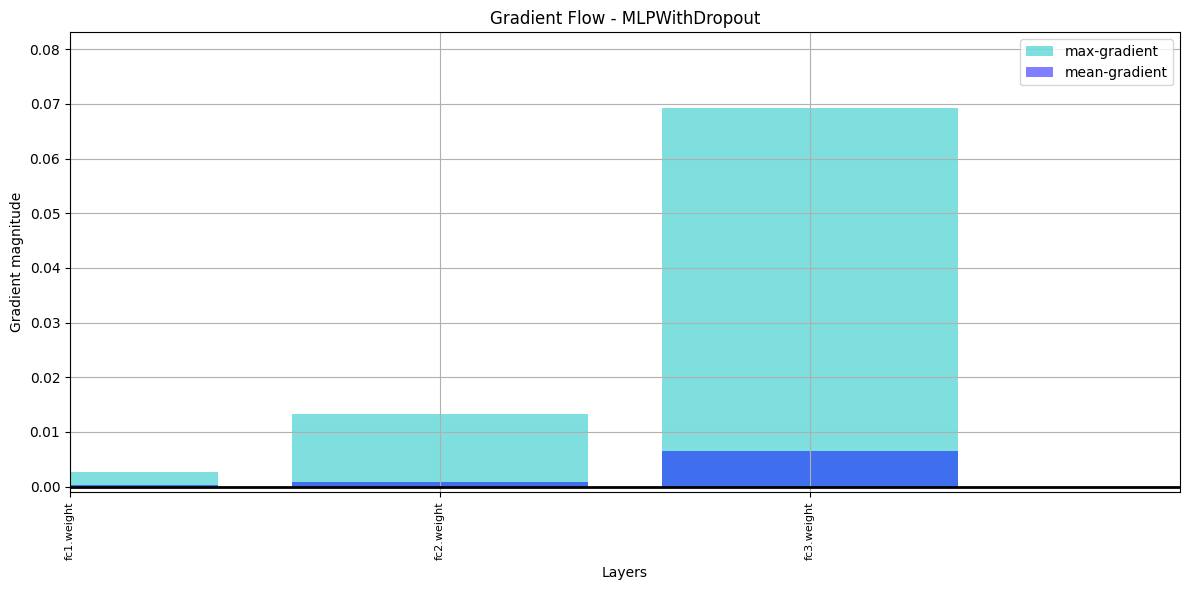

Visualizing gradient flow for MLPWithBatchNormDropout...


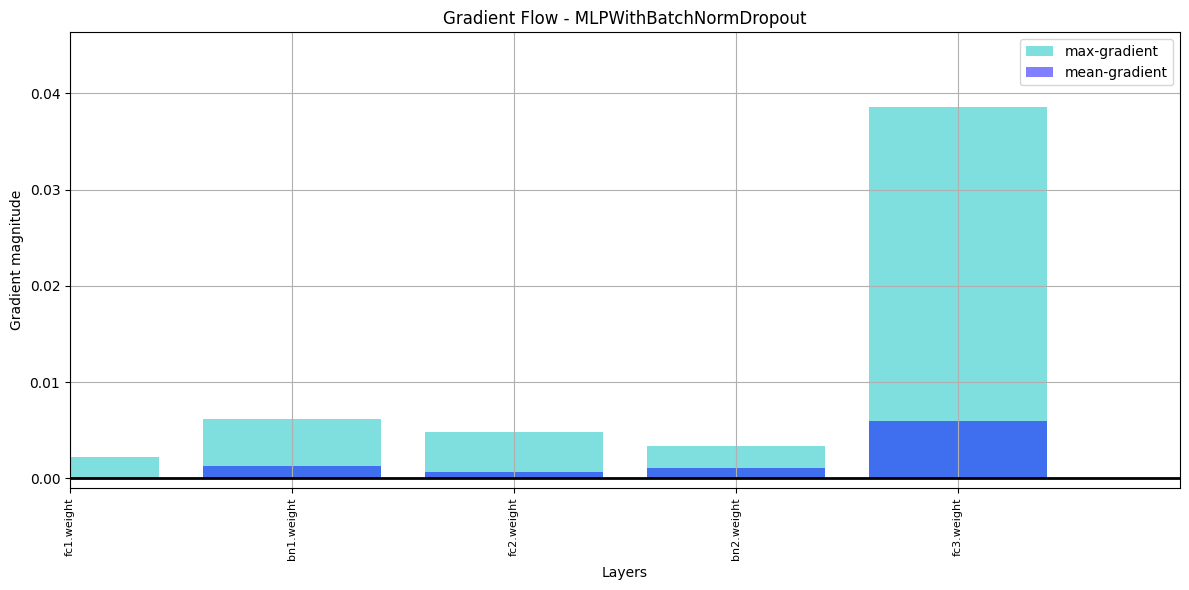

Visualizing gradient flow for DeepResidualMLP...


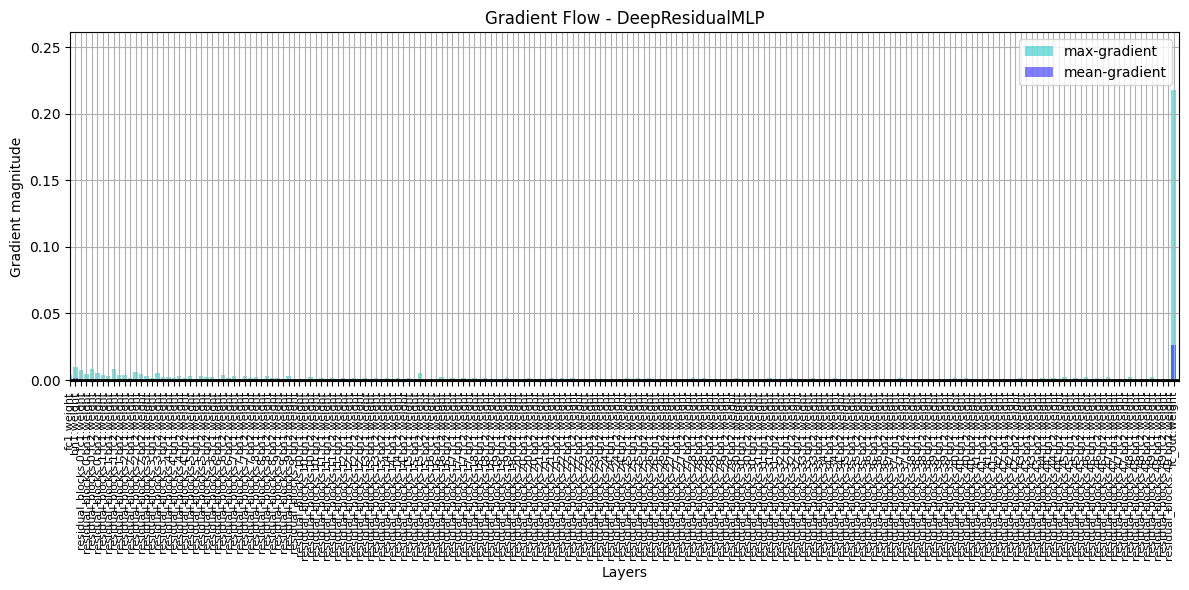

In [30]:
from typing import Optional
def plot_gradient_flow(model, model_name: str, save_path: Optional[str] = None):
    """Visualize gradient flow through the network during backpropagation."""
    ave_grads = []
    max_grads = []
    layers = []
    
    for name, param in model.named_parameters():
        if param.requires_grad and ("bias" not in name) and param.grad is not None:
            layers.append(name)
            ave_grads.append(param.grad.abs().mean().cpu().item())
            max_grads.append(param.grad.abs().max().cpu().item())
    
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.5, lw=1, color="c", label="max-gradient")
    plt.bar(np.arange(len(ave_grads)), ave_grads, alpha=0.5, lw=1, color="b", label="mean-gradient")
    plt.hlines(0, 0, len(ave_grads) + 1, lw=2, color="k")
    plt.xticks(range(len(ave_grads)), layers, rotation="vertical", fontsize=8)
    plt.xlim(left=0, right=len(ave_grads))
    if max_grads:
        plt.ylim(bottom=-0.001, top=max(max_grads) * 1.2)
    plt.xlabel("Layers")
    plt.ylabel("Gradient magnitude")
    plt.title(f"Gradient Flow - {model_name}")
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Use a single mini-batch to inspect gradient flow
sample_images, sample_labels = next(iter(trainloader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)

models_for_gradients = [
    (simple_mlp, "SimpleMLP", "results/gradient_flow_simpleMLP.png"),
    (bn_mlp, "MLPWithBatchNorm", "results/gradient_flow_batchnorm.png"),
    (dropout_mlp, "MLPWithDropout", "results/gradient_flow_dropout.png"),
    (bn_dropout_mlp, "MLPWithBatchNormDropout", "results/gradient_flow_batchnorm_dropout.png"),
    (residual_mlp, "DeepResidualMLP", "results/gradient_flow_residual.png"),
]

for model, name, path in models_for_gradients:
    print(f"Visualizing gradient flow for {name}...")
    model.zero_grad()
    outputs = model(sample_images)
    grad_loss = nn.CrossEntropyLoss()(outputs, sample_labels)
    grad_loss.backward()
    plot_gradient_flow(model, name, save_path=path)